In [22]:
import numpy as np


# all array inputs must be of the type np.array

class my_env:
    #def __init__(self, uav_number, user_number, size, user_loc, noise, height, transmit_pow, safe_dist): # initializes environment
    def __init__(self):
        self.uav_number = 2
        self.user_number = 5
        self.size = np.array([10,10])
        self.user_loc = np.array([[-5,-5,5,5,0],[-5,5,-5,5,0]])
        self.safe_dist = 5
        self.noise = 0.01
        self.height = 7
        self.transmit_pow = 1
        self.observation_space = 2*self.uav_number + self.user_number

        ### Parameters
        self.actions = 5 # 0: 10 units Left , 1: 10 units up , 2: 10 units right, 3: 10 units down, 4: stay
        self.user_profile = 1*np.ones(self.user_number)
        ###

    def my_reward(self, uav_loc, scheduling, user_prof): # calculate reward
        num_agents = np.shape(uav_loc)[1]
        num_user = np.shape(self.user_loc)[1]

        pref = np.zeros((num_agents,num_user))
        pref_rate = np.zeros((num_agents,num_user))
        for i in range(np.shape(pref)[0]):
            for j in range(np.shape(pref)[1]):
                interf = 0
                for k in range(np.shape(pref)[0]):
                    if k != i:
                        interf = interf + self.transmit_pow/(self.height**2 + np.linalg.norm(uav_loc[:,k]-self.user_loc[:,j]))
                pref[i,j] = user_prof[j]*np.log2(1 + self.transmit_pow/(self.height**2 + np.linalg.norm(uav_loc[:,i]-self.user_loc[:,j]))/(interf+self.noise))
                #pref[i,j] = np.log2(1 + self.transmit_pow/(self.height**2 + np.linalg.norm(uav_loc[:,i]-self.user_loc[:,j]))/(interf+self.noise))


        ####### ---- penalty
        penalty = 0

        for i in range(np.shape(pref)[0]):
            for k in range(np.shape(pref)[0]):
                if k != i:
                    penalty = penalty + (np.linalg.norm(uav_loc[:,k]-uav_loc[:,i]) < self.safe_dist)

        # reward = np.sum(np.multiply(scheduling,pref)) - np.log2(1 + self.transmit_pow/(self.height**2)/self.noise )*penalty/2
        reward = np.sum(np.multiply(scheduling,pref)) - 1000*penalty/2

        if penalty != 0:
            done =  True
        else: 
            done = False
        
        return reward , done


    def next_state(self, action1, uav_loc, user_prof, scheduling):
        if action1<5:
            action = np.base_repr(action1,base=5,padding = 1)
        else :
            action = np.base_repr(action1,base=5,padding = 0)

        for i in range(len(action)):
            if action[i] == "0":

                uav_loc[:,i] = uav_loc[:,i] + (-2*np.array([1,0]))
                uav_loc[0,i] = uav_loc[0,i] + (uav_loc[0,i]<-self.size[0]/2)*(-self.size[0]/2-uav_loc[0,i])

            elif action[i] == "1":

                uav_loc[:,i] = uav_loc[:,i] + (2*np.array([0,1]))
                uav_loc[1,i] = uav_loc[1,i] + (uav_loc[1,i]>self.size[1]/2)*(self.size[1]/2-uav_loc[1,i])

            elif action[i] == "2":

                uav_loc[:,i] = uav_loc[:,i] + (2*np.array([1,0]))
                uav_loc[0,i] = uav_loc[0,i] + (uav_loc[0,i]>self.size[0]/2)*(self.size[0]/2-uav_loc[0,i])

            elif action[i] == "3":

                uav_loc[:,i] = uav_loc[:,i] + (-2*np.array([0,1]))
                uav_loc[1,i] = uav_loc[1,i] + (uav_loc[1,i]<-self.size[1]/2)*(-self.size[1]/2-uav_loc[1,i])

            else :
                pass

        #user_prof = user_prof + (0.1 * ~(np.sum(scheduling,axis=0)>0))
        # user_prof = user_prof - (np.min(user_prof)>5)*5
        user_prof = 1/(0.9/user_prof + 0.1*np.sum(scheduling,axis=0))

        return np.hstack((uav_loc.flatten() , user_prof))

    def init_state(self):

        while True:
            a = np.random.uniform(-self.size[0]/2,self.size[0]/2,size = (1,self.uav_number))
            b = np.random.uniform(-self.size[1]/2,self.size[1]/2,size = (1,self.uav_number))
            c = np.vstack((a,b))
            if np.linalg.norm(c[:,0]-c[:,1])>self.safe_dist:
                break
        
 

        return np.hstack((a.flatten(),b.flatten(),self.user_profile))



import cvxpy as cp
import numpy as np


def schedule(user_prof,user_loc,UAV_loc,transmit_pow,noise,height):


    num_agents = np.shape(UAV_loc)[1]
    num_user = np.shape(user_loc)[1]

    A = cp.Variable((num_agents,num_user))

    pref = np.zeros((num_agents,num_user))
    for i in range(np.shape(pref)[0]):
        for j in range(np.shape(pref)[1]):
            interf = 0
            for k in range(np.shape(pref)[0]):
                if k != i:
                    interf = interf + transmit_pow/(height**2 + np.linalg.norm(UAV_loc[:,k]-user_loc[:,j]))
            pref[i,j] = user_prof[j]*np.log2(1 + transmit_pow/(height**2 + np.linalg.norm(UAV_loc[:,i]-user_loc[:,j]))/(interf+noise))

    objective = cp.Minimize(-1*cp.sum(cp.multiply(A,pref)))

    constraints = [A>=0,A<=1]
    constraints.append(cp.sum(A,axis = 0) <= 1)
    constraints.append(cp.sum(A,axis = 1) <= 1)

    problem = cp.Problem(objective, constraints)

    problem.solve()

    return np.round(A.value)

In [23]:
import os

print(os.getcwd())

!ls

C:\Users\Digikala\anaconda3\envs\my_temp\quad_RL\final\DDQN
DGN2.ipynb
checkpoint_eps.pth


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import copy
import time

In [25]:
# Hyperparameters

ALPHA = 0.001  # Learning rate

MEMORY_SIZE = 1  # Size of experience replay memory



# Experience replay memory
memory = deque(maxlen=MEMORY_SIZE)


# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


# Define the Q-network using

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, output_dim)

        nn.init.zeros_(self.fc4.weight)
        nn.init.zeros_(self.fc4.bias)


    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # Output Q-values for each action

# Initialize environment, model, and optimizer
quad_env = my_env()
input_dim =quad_env.observation_space  # State space dimension
output_dim = quad_env.actions  # Action space size

q1_net = QNetwork(input_dim, output_dim).to(DEVICE)
q2_net = QNetwork(input_dim, output_dim).to(DEVICE)

optimizer1 = optim.Adam(q1_net.parameters(), lr=ALPHA)
optimizer2 = optim.Adam(q2_net.parameters(), lr=ALPHA)

loss_fn = nn.MSELoss()



Using device: cuda


## function defs

In [26]:
# Function to select an action using epsilon-greedy policy
def select_action(state, epsilon, q_net):
    if random.random() < epsilon:
        return random.randint(0, quad_env.actions-1)  # Exploration: random action
    else:
        state = torch.FloatTensor(state).to(DEVICE)  # Convert state to tensor
        q_values = q_net(state)
        return torch.argmax(q_values).item()  # Exploitation: action with highest Q-value

# Function to store experiences in memory
def store_experience(state, action1, action2, reward, next_state, done):
    memory.append((state, action1, action2, reward, next_state, done))


def weight_change(model1,model2):
    weight_diff = 0
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight_diff += torch.sum(torch.abs(param1 - param2)).item()
    return weight_diff


# Function to update the Q-values using experience replay
def update_q_network(batch_size):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    
    states, actions1, actions2, rewards, next_states , done = zip(*batch)

    states = torch.FloatTensor(np.array(states)).to(DEVICE)
    next_states = torch.FloatTensor(np.array(next_states)).to(DEVICE)
    actions1 = torch.LongTensor(actions1).to(DEVICE)
    actions2 = torch.LongTensor(actions2).to(DEVICE)
    rewards = torch.FloatTensor(rewards).to(DEVICE)
    done = torch.BoolTensor(done).to(DEVICE)


    # Get current Q-values for the actions taken
    q_values1 = q1_net(states)
    q_values2 = q2_net(states)


    current_q_values1 = q_values1.gather(1, actions1.unsqueeze(1))
    current_q_values2 = q_values2.gather(1, actions2.unsqueeze(1))


    # Get the maximum Q-values for the next states

    next_q_values1 = q1_net(next_states).max(1)[0].unsqueeze(1)
    next_q_values2 = q2_net(next_states).max(1)[0].unsqueeze(1)
    
    target_q_values1 = rewards.unsqueeze(1) + (GAMMA * next_q_values1)*(~(done.unsqueeze(1)))
    target_q_values2 = rewards.unsqueeze(1) + (GAMMA * next_q_values2)*(~(done.unsqueeze(1)))
    
    # Compute the loss
    # loss1 = loss_fn(current_q_values1, torch.max(current_q_values1,target_q_values1))
    # loss2 = loss_fn(current_q_values2, torch.max(current_q_values2,target_q_values2))

    loss1 = loss_fn(current_q_values1, target_q_values1)
    loss2 = loss_fn(current_q_values2, target_q_values2)

    # Update model 1
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

    # Update model 2
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

In [27]:
# Hyperparameters
ALPHA = 0.001  # Learning rate
GAMMA = 0.99  # Discount factor
EPSILON = 1.0  # Exploration rate
EPSILON_DECAY = 0.99885  # Decay rate for epsilon
MIN_EPSILON = 0.0001  # Minimum epsilon value
BATCH_SIZE = 1  # Batch size for experience replay
MEMORY_SIZE = 5000  # Size of experience replay memory
NUM_EPS = 10000  # Number of training episodes
TARG_RATE = 20 # Update rate of target_net
EPS_LEN = 200
TAU_POLYAK = 0.005

#total_reward = 0

#reward_acul = np.empty(0)


#state = quad_env.init_state()

tic = time.time()

reward_acul = np.empty(0)

# Train the agent
for i in range(1,NUM_EPS+1):
    done = False


    state = quad_env.init_state()
    
    total_reward = 0

    
    for j in range(1,EPS_LEN+1):
        if done :
            break

        uav_loc = np.reshape(state[:-quad_env.user_number], (2,-1))
        user_profile = state[-quad_env.user_number:]
    
        action1 = select_action(state, EPSILON, q1_net)
        action2 = select_action(state, EPSILON, q2_net)
        action = action1*5+action2
    
        scheduling = schedule(user_profile,quad_env.user_loc,uav_loc,quad_env.transmit_pow,quad_env.noise,quad_env.height)
    
        next_state = quad_env.next_state(action,uav_loc,user_profile,scheduling)
    
        uav_loc = np.reshape(next_state[:-quad_env.user_number], (2,-1))
    
        
        reward , done = quad_env.my_reward(uav_loc, scheduling, user_profile)
    

        store_experience(state, action1, action2, reward, next_state ,done)
    
    
        #########################################################################################################################
        prev_model1 = copy.deepcopy(q1_net)
        prev_model2 = copy.deepcopy(q2_net)
    
        update_q_network(BATCH_SIZE)
    
        #break ###################################################
    
        ### polyak averaging for updating target_net    
        # for target_param, main_param in zip(target_net.parameters(), q_net.parameters()):
        #     target_param.data.copy_(TAU_POLYAK * main_param.data + (1 - TAU_POLYAK) * target_param.data)
        

        state = next_state
        
        total_reward += reward


    reward_acul = np.append(reward_acul,total_reward)

    # Decay epsilon to reduce exploration
    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

    # Print progress every episodes

    if i%10 == 0:
        toc = time.time()
        print(f"episode {i}/{NUM_EPS}, Eps Reward: {np.mean(reward_acul[-10:])}, Epsilon: {EPSILON}, weights1: {weight_change(q1_net,prev_model1)}, weights2: {weight_change(q2_net,prev_model2)}, elapsed: {(toc-tic)/60} minutes")

    if i%100 == 0:
    
        check_point = {
        'epoch':i,
        'model1_state':q1_net.state_dict(),
        'optimizer1_state': optimizer1.state_dict(),
        'model2_state':q2_net.state_dict(),
        'optimizer2_state': optimizer2.state_dict()
        }
    
        torch.save(check_point,"checkpoint_eps.pth")



episode 10/10000, Eps Reward: -978.2780125039405, Epsilon: 0.988559330361785, weights1: 42.04022794216871, weights2: 45.935443363152444, elapsed: 0.023990225791931153 minutes
episode 20/10000, Eps Reward: -937.5690594311594, Epsilon: 0.9772495496453408, weights1: 46.91756030777469, weights2: 43.0684074703604, elapsed: 0.07515546083450317 minutes
episode 30/10000, Eps Reward: -968.320216933788, Epsilon: 0.9660691603937541, weights1: 17.29286894854158, weights2: 19.450491739436984, elapsed: 0.10587803920110067 minutes
episode 40/10000, Eps Reward: -986.9892740970696, Epsilon: 0.9550166822820216, weights1: 48.803216798231006, weights2: 47.65395338088274, elapsed: 0.12097322543462118 minutes
episode 50/10000, Eps Reward: -974.4247175314682, Epsilon: 0.9440906519210489, weights1: 8.552091859281063, weights2: 20.86193467117846, elapsed: 0.14594053427378337 minutes
episode 60/10000, Eps Reward: -985.961111167537, Epsilon: 0.9332896226638931, weights1: 18.460398953408003, weights2: 19.67981284

In [28]:
np.save("rewards.npy",reward_acul)

<function matplotlib.pyplot.show(close=None, block=None)>

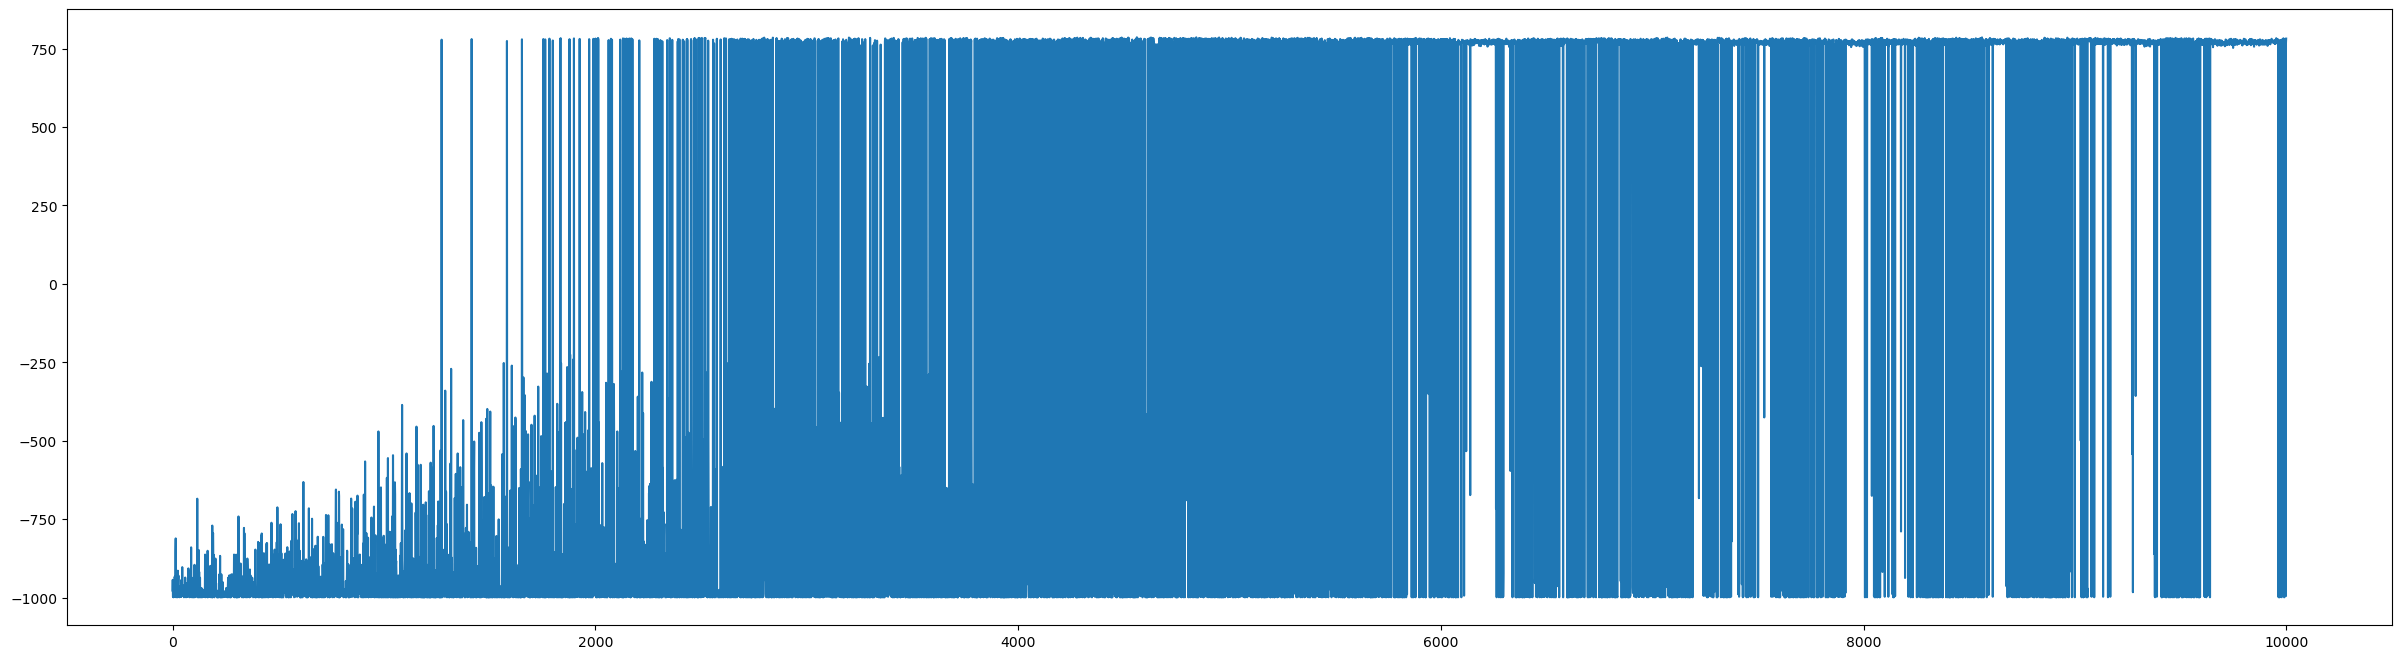

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 8))

plt.plot(np.arange(len(reward_acul)),reward_acul)

plt.show